In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [2]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


# Get Data Spectra

In [3]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (wdtable['centre_beta'] < hbeta + 5)*
    (wdtable['centre_beta'] > hbeta - 5)*
    (wdtable['centre_alpha'] > halpha - 5)*
    (wdtable['centre_alpha'] < halpha + 5) * 
    (~np.isnan(wdtable['loggH']))*
    (~np.isnan(wdtable['TeffH']))*
    (wdtable['TeffH'] > 13000) * 
    (wdtable['TeffH'] < 80000) * 
    (wdtable['subclass'] == 'WD')[:,0].data*
    (wdtable['S2N'] > 2.5)
)
notgoodtable = wdtable[~good]
wdtable = wdtable[good]
len(wdtable)

1188

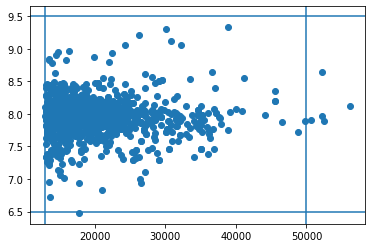

In [4]:
plt.scatter(wdtable['TeffH'],wdtable['loggH'])
plt.axhline(6.5)
plt.axhline(9.5)
plt.axvline(13000)
plt.axvline(50000)

In [5]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

def rvcorr(spectrum):
    lamgrid = np.arange(4000,8000)
    coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
    coremask = coremask.astype(int)
    trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
    if trans > 5:
        trans = 5;
    elif trans < 5:
        trans = -5;
    else:
        ;
    shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
    return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)

100%|██████████| 1188/1188 [04:14<00:00,  3.88it/s]


In [6]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [7]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 1188/1188 [00:03<00:00, 341.80it/s]


1188

# Train Generator

In [8]:
sc = StandardScaler()

X = sc.fit_transform(np.stack((bprps,gs)).transpose())
t = normspec
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1,random_state=13)

In [9]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(10,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(10,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(3000,activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.01), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())

W0731 16:33:30.804550 47119061607744 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 16:33:30.828663 47119061607744 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 16:33:30.831150 47119061607744 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 16:33:30.841634 47119061607744 deprecation_wrapper.py:119] From /home-4/vchandr8@jhu.edu/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3000)              33000     
Total params: 33,140
Trainable params: 33,140
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
epoch = 1000
batch = len(X_train)

history = model.fit(X_train,y_train,epochs=epoch,verbose=1,batch_size=batch,validation_data = (X_test,y_test))

Train on 1069 samples, validate on 119 samples
Epoch 1/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12610.3213 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2896
Epoch 2/1000
1069/1069 [==============================] - 0s 32us/step - loss: 0.0038 - mean_absolute_percentage_error: 12665.2920 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2944
Epoch 3/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0038 - mean_absolute_percentage_error: 12670.8760 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2958
Epoch 4/1000
1069/1069 [==============================] - 0s 27us/step - loss: 0.0037 - mean_absolute_percentage_error: 12552.2363 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2949
Epoch 5/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0037 - mean_absolute_percentage_error: 12680.6484 - val_loss: 0.0018 - val_mean_absolute_per

Epoch 43/1000
1069/1069 [==============================] - 0s 30us/step - loss: 0.0037 - mean_absolute_percentage_error: 12639.2178 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2963
Epoch 44/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0038 - mean_absolute_percentage_error: 12722.9688 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2958
Epoch 45/1000
1069/1069 [==============================] - 0s 27us/step - loss: 0.0038 - mean_absolute_percentage_error: 12628.9756 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2963
Epoch 46/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12609.7578 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2981
Epoch 47/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12592.7773 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2993
Epoch 48/1000
1069/1

Epoch 85/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12557.8936 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2937
Epoch 86/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12580.7334 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2957
Epoch 87/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12730.7461 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2986
Epoch 88/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12604.0371 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.3014
Epoch 89/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0037 - mean_absolute_percentage_error: 12604.7578 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.3018
Epoch 90/1000
1069/1

Epoch 127/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12562.6973 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2905
Epoch 128/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12562.7158 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2883
Epoch 129/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12605.1973 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2879
Epoch 130/1000
1069/1069 [==============================] - 0s 31us/step - loss: 0.0037 - mean_absolute_percentage_error: 12686.8652 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2874
Epoch 131/1000
1069/1069 [==============================] - 0s 33us/step - loss: 0.0037 - mean_absolute_percentage_error: 12613.6553 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2861
Epoch 132/1000


Epoch 169/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12554.1992 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2922
Epoch 170/1000
1069/1069 [==============================] - 0s 42us/step - loss: 0.0037 - mean_absolute_percentage_error: 12572.7471 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2914
Epoch 171/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12710.6631 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2911
Epoch 172/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12588.5742 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2918
Epoch 173/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12707.2822 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2946
Epoch 174/1000


Epoch 211/1000
1069/1069 [==============================] - 0s 34us/step - loss: 0.0038 - mean_absolute_percentage_error: 12669.1475 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2902
Epoch 212/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0038 - mean_absolute_percentage_error: 12677.1006 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2886
Epoch 213/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12614.9326 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2881
Epoch 214/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12595.6523 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2874
Epoch 215/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0038 - mean_absolute_percentage_error: 12592.9629 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2847
Epoch 216/1000


Epoch 253/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0038 - mean_absolute_percentage_error: 12638.2559 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2879
Epoch 254/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12607.2891 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2886
Epoch 255/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12590.6992 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2916
Epoch 256/1000
1069/1069 [==============================] - 0s 28us/step - loss: 0.0038 - mean_absolute_percentage_error: 12695.1221 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2959
Epoch 257/1000
1069/1069 [==============================] - 0s 30us/step - loss: 0.0037 - mean_absolute_percentage_error: 12571.9912 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2986
Epoch 258/1000


Epoch 295/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12632.4375 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2919
Epoch 296/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12660.4932 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2906
Epoch 297/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0037 - mean_absolute_percentage_error: 12614.3945 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2895
Epoch 298/1000
1069/1069 [==============================] - 0s 29us/step - loss: 0.0038 - mean_absolute_percentage_error: 12601.5391 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2882
Epoch 299/1000
1069/1069 [==============================] - 0s 32us/step - loss: 0.0037 - mean_absolute_percentage_error: 12681.4023 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2876
Epoch 300/1000


Epoch 337/1000
1069/1069 [==============================] - 0s 47us/step - loss: 0.0037 - mean_absolute_percentage_error: 12615.5449 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2773
Epoch 338/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12591.0752 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2780
Epoch 339/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12677.7607 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2814
Epoch 340/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12763.9355 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2872
Epoch 341/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12607.9326 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2960
Epoch 342/1000


Epoch 379/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12554.1641 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.3026
Epoch 380/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12563.2344 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2987
Epoch 381/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12711.4834 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2969
Epoch 382/1000
1069/1069 [==============================] - 0s 47us/step - loss: 0.0037 - mean_absolute_percentage_error: 12582.7461 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2963
Epoch 383/1000
1069/1069 [==============================] - 0s 47us/step - loss: 0.0038 - mean_absolute_percentage_error: 12569.7842 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2959
Epoch 384/1000


Epoch 421/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12640.7832 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2901
Epoch 422/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12576.4912 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2882
Epoch 423/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12616.0498 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2879
Epoch 424/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12695.3604 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2856
Epoch 425/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12553.4873 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2828
Epoch 426/1000


Epoch 463/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12623.9531 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2789
Epoch 464/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12585.9268 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2777
Epoch 465/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12623.8428 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2771
Epoch 466/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12567.4033 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2808
Epoch 467/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12634.9111 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2826
Epoch 468/1000


Epoch 505/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12654.6836 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2863
Epoch 506/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12757.8252 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2917
Epoch 507/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12627.4521 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2968
Epoch 508/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12609.2715 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2982
Epoch 509/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12694.5791 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2971
Epoch 510/1000


Epoch 547/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12609.5439 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2985
Epoch 548/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12576.4531 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2961
Epoch 549/1000
1069/1069 [==============================] - 0s 48us/step - loss: 0.0037 - mean_absolute_percentage_error: 12738.3086 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2938
Epoch 550/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12635.6514 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2901
Epoch 551/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12592.3115 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2859
Epoch 552/1000


Epoch 589/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12595.9141 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2906
Epoch 590/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12583.2617 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2904
Epoch 591/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12587.2266 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2917
Epoch 592/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12613.1348 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2920
Epoch 593/1000
1069/1069 [==============================] - 0s 47us/step - loss: 0.0037 - mean_absolute_percentage_error: 12692.8701 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2917
Epoch 594/1000


Epoch 631/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12598.8994 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2928
Epoch 632/1000
1069/1069 [==============================] - 0s 47us/step - loss: 0.0038 - mean_absolute_percentage_error: 12578.3525 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2891
Epoch 633/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12579.6709 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2860
Epoch 634/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12613.5664 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2836
Epoch 635/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12629.8086 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2821
Epoch 636/1000


Epoch 673/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0037 - mean_absolute_percentage_error: 12574.7383 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2911
Epoch 674/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12579.4111 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2912
Epoch 675/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12588.9775 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2909
Epoch 676/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12609.9600 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2908
Epoch 677/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12550.8848 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2898
Epoch 678/1000


Epoch 715/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12508.7285 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2872
Epoch 716/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12601.8115 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2880
Epoch 717/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12552.6279 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2944
Epoch 718/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12535.5732 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.3020
Epoch 719/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12743.8643 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.3070
Epoch 720/1000


Epoch 757/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12643.4121 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2971
Epoch 758/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12635.3281 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2942
Epoch 759/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0037 - mean_absolute_percentage_error: 12615.4795 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2894
Epoch 760/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12652.5732 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2870
Epoch 761/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12606.2754 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2867
Epoch 762/1000


Epoch 799/1000
1069/1069 [==============================] - 0s 35us/step - loss: 0.0038 - mean_absolute_percentage_error: 12636.8955 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2932
Epoch 800/1000
1069/1069 [==============================] - 0s 34us/step - loss: 0.0038 - mean_absolute_percentage_error: 12734.1133 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2964
Epoch 801/1000
1069/1069 [==============================] - 0s 33us/step - loss: 0.0037 - mean_absolute_percentage_error: 12596.8828 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2969
Epoch 802/1000
1069/1069 [==============================] - 0s 32us/step - loss: 0.0038 - mean_absolute_percentage_error: 12607.8828 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2958
Epoch 803/1000
1069/1069 [==============================] - 0s 31us/step - loss: 0.0037 - mean_absolute_percentage_error: 12636.2090 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2938
Epoch 804/1000


Epoch 841/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12848.8340 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2984
Epoch 842/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12575.5684 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2944
Epoch 843/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12568.0156 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2904
Epoch 844/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0037 - mean_absolute_percentage_error: 12632.9062 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2866
Epoch 845/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12629.1016 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2853
Epoch 846/1000


Epoch 883/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12658.8281 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.3048
Epoch 884/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12741.6670 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.3017
Epoch 885/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12594.0557 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2987
Epoch 886/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0037 - mean_absolute_percentage_error: 12567.7695 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2956
Epoch 887/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12810.4385 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2948
Epoch 888/1000


Epoch 925/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12495.2998 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2913
Epoch 926/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0037 - mean_absolute_percentage_error: 12634.7666 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2920
Epoch 927/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12561.8047 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2934
Epoch 928/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12572.7383 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2906
Epoch 929/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0038 - mean_absolute_percentage_error: 12760.8164 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2883
Epoch 930/1000


Epoch 967/1000
1069/1069 [==============================] - 0s 46us/step - loss: 0.0037 - mean_absolute_percentage_error: 12569.5664 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2909
Epoch 968/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12607.7939 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2857
Epoch 969/1000
1069/1069 [==============================] - 0s 44us/step - loss: 0.0038 - mean_absolute_percentage_error: 12625.3809 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2811
Epoch 970/1000
1069/1069 [==============================] - 0s 43us/step - loss: 0.0037 - mean_absolute_percentage_error: 12660.6064 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2767
Epoch 971/1000
1069/1069 [==============================] - 0s 45us/step - loss: 0.0038 - mean_absolute_percentage_error: 12622.5312 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.2755
Epoch 972/1000


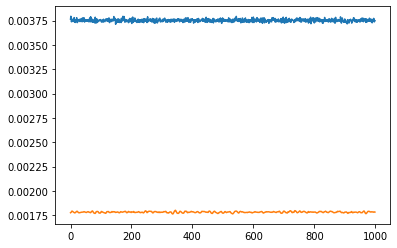

In [38]:
plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))

### Evaluate BP-RP Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

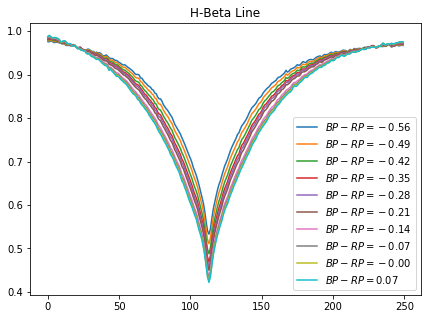

In [39]:
plt.figure(figsize=(7,5))
ts = np.linspace(min(bprps),max(bprps),10)
ls = np.linspace(np.mean(gs),np.mean(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$BP-RP = %.2f$'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate G_abs Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

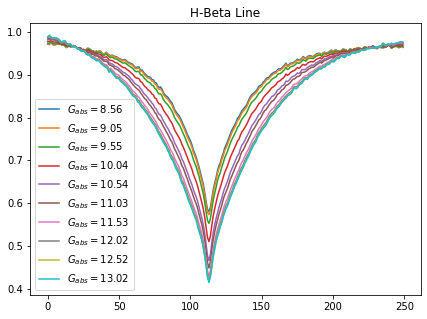

In [40]:
plt.figure(figsize=(7,5))
ts = np.linspace(np.mean(bprps),np.mean(bprps),10)
ls = np.linspace(min(gs),max(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$G_{abs} = %.2f$'%ls[i])

plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate Residuals of Random Control Spectra

Text(0.5, 1.0, 'Sample of Model Residuals')

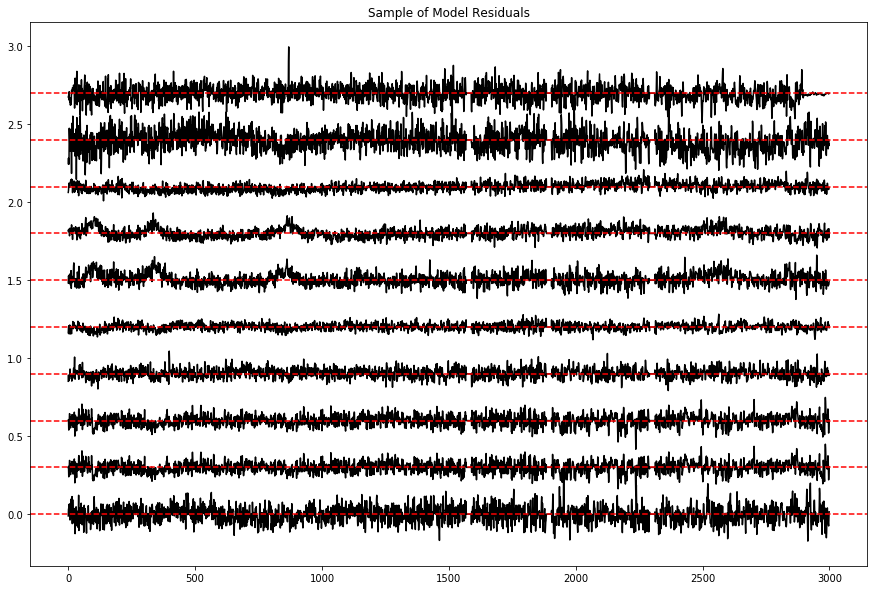

In [41]:
resids = y_test - model.predict(X_test)
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.3*ct,'k')
    plt.axhline(0.3*ct,color='r',linestyle='--')
    ct += 1
plt.title('Sample of Model Residuals')

In [42]:
def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    return interpolation.shift(model.predict(label)[0],trans,cval=np.nan)

def chisquare(residual):
    return sum(residual**2)

In [43]:
lamgrid = np.arange(4000,7000)
fitter = lmfit.Model(spectrum_sampler)
params = fitter.make_params(teff = 20000.,logg=8.,trans=0.)
params['teff'].set(min=min(bprps),max=max(bprps))
params['logg'].set(min=min(gs),max=max(gs))
params['trans'].set(min=-10,max=10)

In [1]:
fitoutput = np.zeros((len(y_test),5))

for i in tqdm(range(len(y_test))):
    spec = y_test[i]
    fitoutput[i,0] = int(specnames[i][:-12])
    params['teff'].set(value=sc.inverse_transform(X_test)[i,0],vary=False)
    result = fitter.fit(spec[coremask],params,wl=lamgrid[coremask],method="powell",nan_policy='omit',calc_covar=True)
    fitoutput[i,1] = result.params['teff'].value
    fitoutput[i,2] = result.params['teff'].stderr
    fitoutput[i,3] = result.params['logg'].value
    fitoutput[i,4] = result.params['logg'].stderr
    
#     plt.figure(figsize=(7,5))
#     plt.plot(spec)
#     plt.plot(spectrum_sampler(None,result.params['teff'],result.params['logg'],result.params['trans']))
#     plt.show()

NameError: name 'np' is not defined

In [49]:
true_labels = sc.inverse_transform(X_test)

Text(0.5, 1.0, 'Data-Driven Generator')

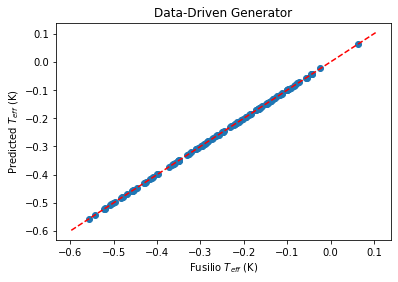

In [50]:
true = true_labels[:,0]
pred = fitoutput[:,1]
f=plt.scatter(true,pred)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Data-Driven Generator')

Text(0.5, 1.0, 'Data-Driven Generator')

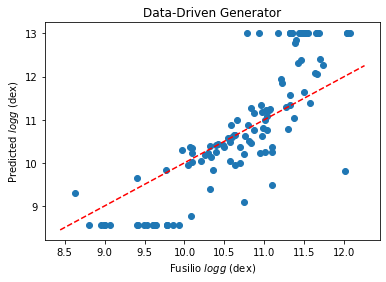

In [52]:
true = true_labels[:,1]
pred = fitoutput[:,3]
f=plt.scatter(true,pred)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.xlabel('Fusilio $logg$ (dex)')
plt.ylabel('Predicted $logg$ (dex)')
plt.title('Data-Driven Generator')

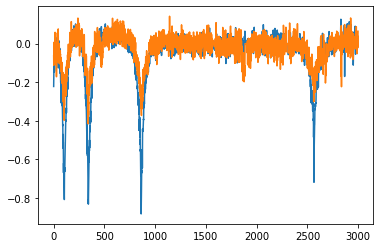

In [66]:
plt.plot(np.log(normspec[1]))
plt.plot(np.log(normspec[3]))